# Processing Daily Climate Anomalies using 1982-2011 Climatology

**ABOUT:** Once the daily climatologies have been calculated for the reference period the next step is to subtract these climate means from the sea surface data observations for the full time series.



## Product 2. Daily Global Temperature Anomalies

General Workflow is to Load:
 1. Netcdf files containing observed SST from 1981-Present
 2. Netcdf containing 30-year Climatology Means for each day of the year
 
Next step is to pair each observed daily mean with the appropriate 30-year climatology and calculate the difference

In [3]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os
 
    
# Set the workspace - local/ docker
workspace = "local"

# Root paths
root_locations = {"local"  : "/Users/akemberling/Box/",
                  "docker" : "/home/jovyan/"}


# Set root
box_root = root_locations[workspace]
print(f"Working via {workspace} directory at: {box_root}")


#Suppress divide by NA error that occurs when getting mean from array
np.seterr(divide = 'ignore', invalid = 'ignore')

Working via local directory at: /Users/akemberling/Box/


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Step 1: Open Daily Climatologies 

Daily climate means were calculated in the previous notebook: `01_BASE_Calc_Climatologies` for the 30-year reference period of 1982-2011. In the dimensions we see that the modified ordinal day is present in addition to lat/lon.

In [4]:
#daily_clims = xr.open_dataset('daily_climatologies/daily_clims_82to2011.nc')
daily_clims = xr.open_mfdataset(f'{box_root}RES_Data/OISST/oisst_mainstays/daily_climatologies/daily_clims_1982to2011.nc',
                               combine = "by_coords")
daily_clims

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, modified_ordinal_day: 366)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Data variables:
    sst                   (modified_ordinal_day, lat, lon) float32 dask.array<chunksize=(366, 720, 1440), meta=np.ndarray>

## Step 2: Load Netcdf Files for Daily SST Data
Lazy-load the annual netcdf files for the oisst sst data. Once again we will be taking advantage of {xarray} here to load them as a single object and not repeat steps for each year.

In [5]:
#Load/append all the annual netcdf files
start_year = 1982
end_year = 2020
my_years = np.arange(start_year, end_year, 1)
nc_files = []
for i in my_years:
    nc_files.append(f"{box_root}RES_Data/OISST/oisst_mainstays/annual_observations/sst.day.mean." + str(i) + ".v2.nc")

In [7]:
# Load and append the annual observations as. a single array
sst_obs = xr.open_mfdataset(nc_files, parallel=False, combine='by_coords')

## Step 3: Re-create Modified Ordinal Day Index

To account for leap-years the daily climatology was calculated using a modified ordinal day, with which March 1st is always the 60th day of the of the index, with February 29th occupying the 59th value in the event that it occurs. In order to match the daily observations to these values we need an index of what day of the year it is (that isn't sensitive to leap-years) to match the observed sst values with the 30-year climatologies.

In [8]:
not_leap_year        = ~sst_obs.indexes['time'].is_leap_year
march_or_later       = sst_obs.time.dt.month >= 3
ordinal_day          = sst_obs.time.dt.dayofyear
modified_ordinal_day = ordinal_day + (not_leap_year & march_or_later)
modified_ordinal_day = modified_ordinal_day.rename('modified_ordinal_day')

Now add that dimension to the big observed sst array

In [9]:
#Add modified ordinal day as a variable
sst_obs = sst_obs.assign(modified_ordinal_day = modified_ordinal_day)

#Maybe need to add modified ordinal day as coordinate as well
sst_obs = sst_obs.assign_coords(MOD = modified_ordinal_day)

## Step 4: Validate Structure and matching convention

Critical here to make sure for the anomaly calculation that the correct climatology values are used when calculating the climate anomalies. The next few chunks just examine the array structures and the indexing of their values/

In [23]:
#compare structure to daily climatologies structure
daily_clims

# Does MOD align with the time coord? - Should be 61 for March 1st
sst_obs.sel(time = '2000-03-01')["MOD"]

<xarray.DataArray 'MOD' ()>
array(61)
Coordinates:
    time     datetime64[ns] 2000-03-01
    MOD      int64 61

### Matching them up for arithmetic
So now the observed dataset contains the modified ordinal day of the year which we can use to match with the corresponding daily climatology

In [18]:
# Choose a speccific date to use as a tester
test_day_obs = sst_obs.sel(time = '2000-03-01')
#test_day_obs

# Now using that test day pull the climatology that should match it using MOD/
test_day_clim = daily_clims.sel(modified_ordinal_day = test_day_obs["MOD"])

# Last step is the subtraction of observed sst - climate mean
test_day_anom = test_day_obs - test_day_clim

# rename to sst anomaly to indicate the math that took place
test_day_anom = test_day_anom['sst'].rename('sst_anom')

### Test Day Anomaly - Plot

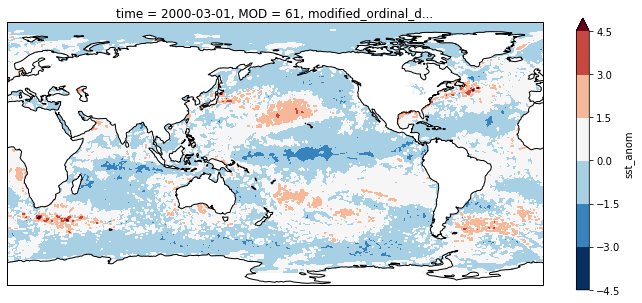

In [19]:
fig = plt.figure(figsize=[12,5])

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))

test_day_anom.plot.contourf(
    ax=ax,
    levels=np.arange(-4.5, 6, 1.5),
    extend='max',
    transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

## Step 5: GroupBy "time": split-apply-combine

So from the full daily set, we want to group by the time to split out each day. Then use the modified ordinal day to subtract the matching climatology. We won't need to worry about leap years because the matching is done with the MOD index.

In [18]:
sst_obs.groupby('time')

DatasetGroupBy, grouped over 'time' 
14199 groups with labels 1982-01-01, ..., 2020-11-15.

Define the function that will take a daily slice of the observed sst, and subtract it by its matching climatology:

In [19]:
def calc_anom(daily_sst):
    return daily_sst - daily_clims.sel(modified_ordinal_day = daily_sst["MOD"])

### Calculate All Anomalies

This is the step where we apply the little subtraction function to all the dates we have. The result is the anomaly array we were after.

In [20]:
daily_anoms = sst_obs.groupby('time').map(calc_anom)
daily_anoms

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 14199)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * time                  (time) datetime64[ns] 1982-01-01 ... 2020-11-15
    MOD                   (time) int64 1 2 3 4 5 6 7 ... 315 316 317 318 319 320
    modified_ordinal_day  (time) int64 1 2 3 4 5 6 7 ... 315 316 317 318 319 320
Data variables:
    sst                   (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

## Validation: Plot some Anomalies

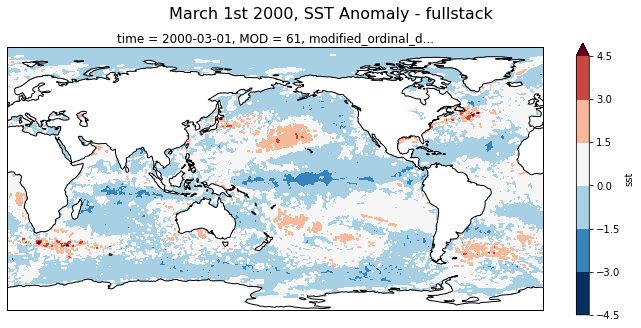

In [21]:
fig = plt.figure(figsize=[12,5])

ax = fig.add_subplot(111, projection = ccrs.PlateCarree(central_longitude = 180))
fig.suptitle('March 1st 2000, SST Anomaly - fullstack', fontsize = 16)

daily_anoms.sel(time = '2000-03-01')['sst'].plot.contourf(
    ax=ax,
    levels=np.arange(-4.5, 6, 1.5),
    extend='max',
    transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

Compare to the single day tester that we did outside of the slit-apply-combine function. 

In [20]:
# fig = plt.figure(figsize=[12,5])

# ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
# fig.suptitle('March 1st 2000, SST Anomaly - single test day', fontsize=16)

# test_day_anom.plot.contourf(
#     ax = ax,
#     levels = np.arange(-4.5, 6, 1.5),
#     extend = 'max',
#     transform = ccrs.PlateCarree())

# ax.coastlines()

# plt.show()

## Update Metadata Attributes:

Just like with the climatology it is good to add metadata attributes.

In [23]:
sst_obs.attrs

{'Conventions': 'CF-1.5',
 'title': 'NOAA High-resolution Blended Analysis: Daily Values using AVHRR only',
 'institution': 'NOAA/NCDC',
 'source': 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/',
 'comment': 'Reynolds, et al., 2007: Daily High-Resolution-Blended Analyses for Sea Surface Temperature. J. Climate, 20, 5473-5496.  Climatology is based on 1971-2000 OI.v2 SST, Satellite data: Navy NOAA17 NOAA18 AVHRR, Ice data: NCEP ice.',
 'history': 'Thu Aug 24 13:35:47 2017: ncatted -O -a References,global,d,, sst.day.mean.1982.v2.nc\nVersion 1.0',
 'references': 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html',
 'dataset_title': 'NOAA Daily Optimum Interpolation Sea Surface Temperature'}

In [24]:
#Change the Attributes for the dataset
daily_anoms.attrs['title']         = 'Sea surface temperature anomalies from NOAA OISSTv2 SST Data using 82-2011 Climatology'
daily_anoms.attrs['institution']   = 'Gulf of Maine Research Institute'
daily_anoms.attrs['source']        = 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/'
daily_anoms.attrs['comment']       = 'Climatology used represents mean SST for the years 1982-2011'
daily_anoms.attrs['history']       = 'Anomalies calculated 3/2/2020'
daily_anoms.attrs['references']    = 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html'
daily_anoms.attrs['dataset_title'] = 'Sea Surface Temperature Anomalies - OISSTv2'
daily_anoms.attrs

{'title': 'Sea surface temperature anomalies from NOAA OISSTv2 SST Data using 82-2011 Climatology',
 'institution': 'Gulf of Maine Research Institute',
 'source': 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/',
 'comment': 'Climatology used represents mean SST for the years 1982-2011',
 'history': 'Anomalies calculated 3/2/2020',
 'references': 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html',
 'dataset_title': 'Sea Surface Temperature Anomalies - OISSTv2'}

In [26]:
#Export as annual netcdf files

# Save to box    
for year, group in daily_anoms.groupby('time.year'):
    group.to_netcdf(f'{box_root}RES_Data/OISST/oisst_mainstays/annual_anomalies/daily_anoms_{year}.nc')
